Testing Notebook 
All testing scripts were given by generative AI

0. Set up of notebook

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

c:\Users\benjo\OneDrive\Documents\Projects\Quant-Tools


1. data_loader.py testing

In [2]:
from quant_tools.data_loader import get_data
df = get_data("AAPL", "2020-01-01", "2020-06-01")
print(df.head())

Loading data from cache...
Price              Adj Close      Close       High        Low       Open  \
Date       Ticker                                                          
2020-01-02 AAPL    72.620842  75.087502  75.150002  73.797501  74.059998   
2020-01-03 AAPL    71.914810  74.357498  75.144997  74.125000  74.287498   
2020-01-06 AAPL    72.487846  74.949997  74.989998  73.187500  73.447502   
2020-01-07 AAPL    72.146927  74.597504  75.224998  74.370003  74.959999   
2020-01-08 AAPL    73.307518  75.797501  76.110001  74.290001  74.290001   

Price                 Volume  
Date       Ticker             
2020-01-02 AAPL    135480400  
2020-01-03 AAPL    146322800  
2020-01-06 AAPL    118387200  
2020-01-07 AAPL    108872000  
2020-01-08 AAPL    132079200  


2. Analysis.py Testing

In [3]:
import quant_tools.analysis as qa
import pandas as pd

close = prices = pd.Series(
    [100, 110, 105, 120],
    index=pd.date_range("2020-01-01", periods=4)
)

log_rets = qa.calculate_log_returns(close)
simp_rets = qa.calculate_returns(close)

ema20 = qa.calculate_moving_avg(close, 20)

vol = qa.calculate_volatility(log_rets)
sharpe = qa.calculate_sharpe_ratio(log_rets, risk_free=0.02)
mdd = qa.calculate_drawdown(close)

print(log_rets,simp_rets,ema20,vol,sharpe,mdd)

2020-01-02    0.095310
2020-01-03   -0.046520
2020-01-04    0.133531
Freq: D, dtype: float64 2020-01-02    0.100000
2020-01-03   -0.045455
2020-01-04    0.142857
Freq: D, dtype: float64 2020-01-01    100.000000
2020-01-02    100.952381
2020-01-03    101.337868
2020-01-04    103.115214
Freq: D, dtype: float64 1.5059207657399618 10.156584010697738 -0.045454545454545414


In [4]:
simp = pd.Series([0.1, -0.05, 0.142857], index=pd.date_range("2020-01-02", periods=3))

print("CumRet:", qa.cum_returns(simp))                
print("CAGR:", qa.cagr(simp, periods_per_year=3))            

print("Sortino:", qa.sortino_ratio(simp))                    
print("Calmar:", qa.calmar_ratio(simp, periods_per_year=3))  

print("VaR 5% hist:", qa.VaR_calc(simp, 0.05))          
print("ES 5% hist:", qa.expected_shortfall(simp, 0.05))      

CumRet: 0.19428556499999994
CAGR: 0.19428556499999994
Sortino: 20.41006642391935
Calmar: 3.8857112999999868
VaR 5% hist: -0.035
ES 5% hist: -0.05


3. Testing Pricing, simulations, backtester and greeks functions

=== 3) BACKTESTER (MovingAverage) ===
Loading data from cache...


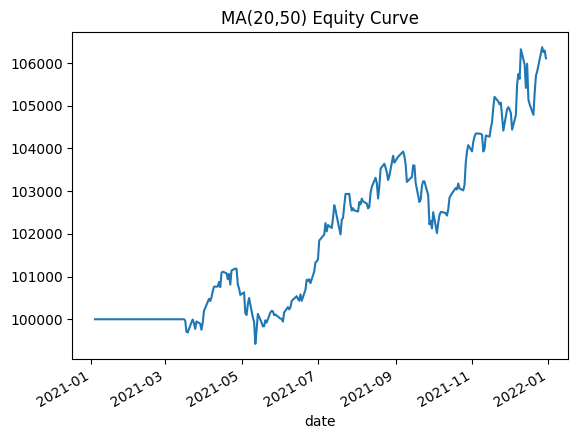

 • Backtest Sharpe Ratio = 1.781
 • Max Drawdown    = -1.84%
 • Backtester OK



In [ ]:
# %% [markdown]
# # Sanity‑Check: Simulations, Pricing, Greeks & Backtester (MovingAverage)

# %% code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from quant_tools.simulations  import sim_rand_walk, gbm
from quant_tools.pricing      import mc_european_call
from quant_tools.greeks       import greeks_estimate
from quant_tools.data_loader  import get_data
from quant_tools.backtester   import Backtester, MovingAverage
from quant_tools.analysis     import (
    calculate_log_returns,
    calculate_sharpe_ratio,
    calculate_drawdown,
    calculate_moving_avg
)

print("=== 1) SIMULATION TESTS ===")

# 1a) Random walk: Series of length n_steps+1
rw = sim_rand_walk(s0=0.0, sigma=1.0, n_steps=100, dt=1.0)
assert isinstance(rw, pd.Series), "sim_rand_walk must return a pandas Series"
assert len(rw) == 101, f"Expected 101 points, got {len(rw)}"
print(" • sim_rand_walk OK")

# 1b) GBM single–path
gbm1 = gbm(s0=100, mu=0.05, sigma=0.2, n_steps=100, dt=1/252, n_paths=1)
assert isinstance(gbm1, pd.DataFrame) and gbm1.shape == (101, 1)
print(" • GBM single‑path OK")

# 1c) GBM multi‑path
gbm5 = gbm(s0=100, mu=0.05, sigma=0.2, n_steps=100, dt=1/252, n_paths=5)
assert isinstance(gbm5, pd.DataFrame) and gbm5.shape == (101, 5)
print(" • GBM multi‑path OK\n")


print("=== 2) PRICER & GREEKS TESTS ===")

params = dict(
    s0=100.0, K=100.0, r=0.01,
    sigma=0.2, T=1.0,
    n_steps=252, n_paths=75_000
)

price = mc_european_call(**params)
delta = greeks_estimate("delta", bump=1e-2, **params)
vega  = greeks_estimate("vega",  bump=1e-2, **params)
theta = greeks_estimate("theta", bump=1/252, **params)

print(f" • Call price ≈ {price:.4f}")
print(f" • Δ = {delta:.4f}, Vega = {vega:.4f}, Θ = {theta:.4f}")

assert delta > 0, "Delta should be positive"
assert vega  > 0, "Vega should be positive"
assert theta < 0, "Theta should be negative"
print(" • Pricer & Greeks OK\n")

print("=== 3) BACKTESTER (MovingAverage) ===")
tickers = ["AAPL",'MSFT']
df_raw = get_data(tickers, "2021-01-01", "2021-12-31")
df = df_raw

strat  = MovingAverage(short_win=20, long_win=50)
bt  = Backtester(data=df, strategy=strat, initial_cash=100_000)
equity = bt.run()

# plot equity curve
equity.plot(title="MA(20,50) Equity Curve")
plt.show()

    # compute performance metrics
rets = calculate_log_returns(equity)
shp  = calculate_sharpe_ratio(rets)
mdd  = calculate_drawdown(equity)

print(f" • Backtest Sharpe Ratio = {shp:.3f}")
print(f" • Max Drawdown    = {mdd:.2%}")

assert isinstance(shp, float)
assert isinstance(mdd, float)
print(" • Backtester OK\n")